In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # For a nice progress bar!
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
def concat_csv():
    # Take the path of all the data
    # Read data
    df = pd.read_csv('/kaggle/input/datasolar/Data_Solar_cut.csv',header=0)
    df.set_index('DATE (MM/DD/YYYY)', inplace=True)
    df = df.fillna(method = 'ffill')
    return df

In [3]:
df = concat_csv()
print(df.info())  # Kiểm tra kiểu dữ liệu

/tmp/ipykernel_35/1504789278.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


<class 'pandas.core.frame.DataFrame'>
Index: 1742341 entries, 2015-01-01 00:00:00 to 2018-04-24 23:00:00
Data columns (total 26 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   Zenith Angle [degrees]                  float64
 1   Azimuth Angle [degrees]                 float64
 2   Airmass                                 float64
 3   Tower Dry Bulb Temp [deg C]             float64
 4   Tower Wet Bulb Temp [deg C]             float64
 5   Tower Dew Point Temp [deg C]            float64
 6   Tower Wind Chill Temp [deg C]           float64
 7   Tower RH [%]                            float64
 8   Total Cloud Cover [%]                   int64  
 9   Opaque Cloud Cover [%]                  int64  
 10  Avg Wind Speed @ 19ft [m/s]             float64
 11  Peak Wind Speed @ 19ft [m/s]            float64
 12  Avg Wind Direction @ 19ft [deg from N]  float64
 13  Vertical Wind Shear [1/s]               float64
 14  Station P

In [4]:
def correlation(dataset, threshold):
     col_corr = set()  # Set of all the names of correlated columns
     corr_matrix = dataset.corr(method='spearman')  # Calculate Spearman correlation
     num_columns = len(corr_matrix.columns)
     for i in range(num_columns):
         if i != 0:
             if abs(corr_matrix.iloc[i,25 ]) < threshold:
                 colname = corr_matrix.columns[i]
                 col_corr.add(colname)
     return col_corr
def get_loader(dataset,batch_size=16,shuffle=False):

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle)
    return loader

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
def ordered_train_val_test_split(df, val_size, test_size):
    # Calculate the splitting indices
    val_index = int(len(df) * (1 - val_size - test_size))
    test_index = int(len(df) * (1 - test_size))

    # Split the DataFrame
    train_data = df.iloc[:val_index]
    val_data = df.iloc[val_index:test_index]
    test_data = df.iloc[test_index:]

    return train_data, val_data, test_data

In [5]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# class LSTM(nn.Module):
#      def __init__(self,input_size=8,hidden_size=256,num_layers=2,seq_length=12):
#          super(LSTM,self).__init__()
#          self.hidden_size = hidden_size
#          self.num_layers = num_layers
#          self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
#          self.fc = nn.Linear(hidden_size*seq_length,seq_length)
#      def forward(self,x):
#          out,(hidden,cell) = self.lstm(x)
#          # out: tensor of shape (batch_size, seq_length, hidden_size)

#          out = out.reshape(out.shape[0],-1)
#          # out: tensor of shape (batch_size, seq_length * hidden_size)

#          out = self.fc(out)
#          # out: shape (batch_size,seq_length)
#          return out

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:

# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers):
#         super(LSTM, self).__init__()
#         self.lstm = nn.LSTM(input_size=input_size,
#                             hidden_size=hidden_size,
#                             num_layers=num_layers,
#                             batch_first=True)

#     def forward(self, x):
#         out, (hidden, cell) = self.lstm(x)
#         return out  # (batch_size, seq_len, hidden_size)
# class CNN(nn.Module):
#     def __init__(self, in_channels):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=3, padding=1)
#         self.pool1 = nn.MaxPool1d(kernel_size=2)  # 24 → 12
#         self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.pool2 = nn.MaxPool1d(kernel_size=2)  # 12 → 6

#     def forward(self, x):
#         x = x.permute(0, 2, 1)       # (batch, features, seq_len)
#         x = F.relu(self.conv1(x))    # → (batch, 64, seq_len)
#         x = self.pool1(x)            # → (batch, 64, 12)
#         x = F.relu(self.conv2(x))    # → (batch, 128, 12)
#         x = self.pool2(x)            # → (batch, 128, 6)
#         x = x.permute(0, 2, 1)       # → (batch, 6, 128)
#         return x
# class CNN_LSTM(nn.Module):
#     def __init__(self, in_channels, lstm_hidden=64, lstm_layers=2, output_seq=24):
#         super(CNN_LSTM, self).__init__()
#         self.encoder = CNN(in_channels)
#         self.decoder = LSTM(input_size=128,
#                             hidden_size=lstm_hidden,
#                             num_layers=lstm_layers)
#         self.fc = nn.Linear(lstm_hidden * 6, output_seq)  # 6 = chuỗi sau CNN

#     def forward(self, x):
#         x = self.encoder(x)              # (batch, 6, 128)
#         out = self.decoder(x)           # (batch, 6, lstm_hidden)
#         out = out.reshape(out.shape[0], -1)  # flatten → (batch, 6*lstm_hidden)
#         out = self.fc(out)              # → (batch, 24)
#         return out

In [8]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CNN(nn.Module):
#     def __init__(self, in_channels):
#         super(CNN, self).__init__()
#         self.conv1d_1 = nn.Conv1d(in_channels=in_channels, out_channels=64, kernel_size=3, padding=1)
#         self.maxpooling_1 = nn.MaxPool1d(kernel_size=2, stride=2)
#         self.conv1d_2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
#         self.maxpooling_2 = nn.MaxPool1d(kernel_size=2, stride=2)

#     def forward(self, x):
#         x = x.permute(0, 2, 1)        # (batch, features, seq_len)
#         x = F.relu(self.conv1d_1(x))
#         x = self.maxpooling_1(x)
#         x = F.relu(self.conv1d_2(x))
#         x = self.maxpooling_2(x)
#         x = x.permute(0, 2, 1)        # (batch, seq_len_after_cnn, features)
#         return x

# class GRU(nn.Module):
#     def __init__(self, input_size=128, hidden_size=256, num_layers=2, seq_length=6, dropout=0.3):
#         super(GRU, self).__init__()
#         self.seq_length = seq_length
#         self.gru = nn.GRU(input_size=input_size,
#                           hidden_size=hidden_size,
#                           num_layers=num_layers,
#                           batch_first=True,
#                           dropout=dropout if num_layers > 1 else 0.0)
#         self.dropout = nn.Dropout(dropout)
#         self.fc = nn.Linear(hidden_size * seq_length, seq_length)

#     def forward(self, x):
#         out, _ = self.gru(x)                 # (batch, seq_length, hidden_size)
#         out = out.reshape(out.shape[0], -1)  # (batch, seq_length * hidden_size)
#         out = self.dropout(out)
#         out = self.fc(out)                   # (batch, seq_length)
#         return out

# class CNN_GRU(nn.Module):
#     def __init__(self, in_channels=8, gru_hidden=256, gru_layers=2, input_seq_len=24, output_seq_len=24, dropout=0.3):
#         super(CNN_GRU, self).__init__()
#         self.encoder = CNN(in_channels)
#         self.seq_len_after_cnn = input_seq_len // 4  # 24 → 6
#         self.decoder = GRU(input_size=128,
#                            hidden_size=gru_hidden,
#                            num_layers=gru_layers,
#                            seq_length=self.seq_len_after_cnn,
#                            dropout=dropout)
#         self.fc_out = nn.Linear(self.seq_len_after_cnn, output_seq_len)

#     def forward(self, x):
#         x = self.encoder(x)        # (batch, 6, 128)
#         out = self.decoder(x)      # (batch, 6)
#         out = self.fc_out(out)     # (batch, 24)
#         return out


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRU(nn.Module):
    def __init__(self, input_size=8, hidden_size=128, num_layers=1, dropout=0.3):
        super(GRU, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

    def forward(self, x):
        out, _ = self.gru(x)  # (batch, seq_len, hidden_size)
        return out

class CNN(nn.Module):
    def __init__(self, in_channels=128, input_seq_len=24, dropout=0.3):
        super(CNN, self).__init__()
        self.seq_len_after_pool = input_seq_len // 4

        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.linear1 = nn.Linear(128 * self.seq_len_after_pool, 256)
        self.linear2 = nn.Linear(256, input_seq_len)

    def forward(self, x):
        x = x.permute(0, 2, 1)         # (batch, hidden_size, seq_len)
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)            # (batch, 128 * seq_len_after_pool)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))    # (batch, 256)
        x = self.linear2(x)            # (batch, seq_len)
        return x

class GRU_CNN(nn.Module):
    def __init__(self, input_size=8, hidden_size=128, num_layers=1, seq_len=24, dropout=0.3):
        super(GRU_CNN, self).__init__()
        self.encoder = GRU(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, dropout=dropout)
        self.decoder = CNN(in_channels=hidden_size, input_seq_len=seq_len,
                           dropout=dropout)

    def forward(self, x):
        x = self.encoder(x)      # (batch, seq_len, hidden_size)
        x = self.decoder(x)      # (batch, seq_len)
        return x


In [10]:
class Irradiation_Dataset(Dataset):
    def __init__(self,data,target,trainop1=True):
        self.data = data # shape [num_samples,num_feature]
        self.target = target # shape [num_samples,1]
        self.trainop1 = trainop1
    def __len__(self):
        if self.trainop1:
            return self.data.shape[0]//24-1
        else:
            return self.data.shape[0]//24

    def __getitem__(self,index):
        if self.trainop1:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = (index+1)*seq_length
            targets_end_idx = targets_start_idx+24
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]

            return torch.tensor(features),torch.tensor(targets)
        else:
            seq_length =  24
            features_start_idx = index*seq_length
            features_end_idx = (index+1)*seq_length

            targets_start_idx = index * seq_length
            targets_end_idx = (index+1)*seq_length
            features = self.data[features_start_idx:features_end_idx, :]
            targets = self.target[targets_start_idx:targets_end_idx]
        return torch.tensor(features),torch.tensor(targets)

In [11]:
df = df.iloc[:, [0, 2, 3, 7, 9, 12, 23, 25]]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1742341 entries, 2015-01-01 00:00:00 to 2018-04-24 23:00:00
Data columns (total 8 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   Zenith Angle [degrees]                  float64
 1   Airmass                                 float64
 2   Tower Dry Bulb Temp [deg C]             float64
 3   Tower RH [%]                            float64
 4   Opaque Cloud Cover [%]                  int64  
 5   Avg Wind Direction @ 19ft [deg from N]  float64
 6   Global Extraterrestrial (calc) [W/m^2]  float64
 7   GHI Mean                                float64
dtypes: float64(7), int64(1)
memory usage: 119.6+ MB
None


In [12]:
target_column = 'GHI Mean'
trainop1 = True

X = df
Y = df[target_column]
Y = pd.DataFrame({target_column: Y})

X_train, X_val, X_test = ordered_train_val_test_split(X,0.1,0.1)
Y_train, Y_val, Y_test = ordered_train_val_test_split(Y,0.1,0.1)

if not trainop1:
    X_train = X_train.drop(target_column,axis=1)
    X_val = X_val.drop(target_column,axis=1)
    X_test = X_test.drop(target_column,axis=1)

In [13]:
X_scaler = StandardScaler()
X_train = pd.DataFrame(X_scaler.fit_transform(X_train), columns=X_train.columns).values
X_val = pd.DataFrame(X_scaler.transform(X_val), columns=X_val.columns).values
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X_test.columns).values


Y_scaler = StandardScaler()
Y_train = pd.DataFrame(Y_scaler.fit_transform(Y_train), columns=Y_train.columns).values
Y_val = pd.DataFrame(Y_scaler.transform(Y_val), columns=Y_val.columns).values
Y_test = pd.DataFrame(Y_scaler.transform(Y_test), columns=Y_test.columns).values

# print(Y_test)

In [14]:
print("The shape of the original data:",df.shape)
print("The shape of the train data:",X_train.shape)
print("The shape of the train target:",Y_train.shape)
print("The shape of the val data:",X_val.shape)
print("The shape of the val target:",Y_val.shape)
print("The shape of the test data:",X_test.shape)
print("The shape of the test target:",Y_test.shape)

train_data = Irradiation_Dataset(X_train,Y_train,trainop1=trainop1)
val_data = Irradiation_Dataset(X_val,Y_val,trainop1=trainop1)
test_data = Irradiation_Dataset(X_test,Y_test,trainop1=trainop1)

print(len(train_data))
print(len(val_data))
print(len(test_data))

train_data_loader = get_loader(train_data)
val_data_loader = get_loader(val_data)
test_data_loader = get_loader(test_data)

The shape of the original data: (1742341, 8)
The shape of the train data: (1393872, 8)
The shape of the train target: (1393872, 1)
The shape of the val data: (174234, 8)
The shape of the val target: (174234, 1)
The shape of the test data: (174235, 8)
The shape of the test target: (174235, 1)
58077
7258
7258


In [15]:
# Lấy 1 batch đầu tiên từ train_data_loader
for batch_x, batch_y in train_data_loader:
    print("Train batch x shape:", batch_x.shape)
    print("Train batch y shape:", batch_y.shape)
    break  # chỉ lấy batch đầu tiên

# Lấy 1 batch đầu tiên từ val_data_loader
for batch_x, batch_y in val_data_loader:
    print("Valid batch x shape:", batch_x.shape)
    print("Valid batch y shape:", batch_y.shape)
    break

Train batch x shape: torch.Size([16, 24, 8])
Train batch y shape: torch.Size([16, 24, 1])
Valid batch x shape: torch.Size([16, 24, 8])
Valid batch y shape: torch.Size([16, 24, 1])


In [16]:
input_size = df.shape[1]
print(input_size)

8


In [17]:
input_size = 8
hidden_size = 64
num_layers = 1
sequence_length = 24
learning_rate = 0.001
batch_size = 16
num_epochs = 300
dropout = 0.3  # thêm nếu bạn dùng Dropout
min_valid_loss = np.inf

model = GRU_CNN(input_size=8,
                hidden_size=64,
                num_layers=2,
                seq_len=24,
                dropout=0.3).to(device)


In [18]:
#LOSS AND OPTIMIZER
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.LinearLR(optimizer=optimizer,
                                        start_factor=1.0,
                                        end_factor=0.01)

In [19]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        """
        patience: số epoch chờ đợi sau khi validation loss không giảm
        min_delta: mức giảm tối thiểu của validation loss để coi là cải thiện
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # reset counter nếu cải thiện
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


In [20]:
 early_stopping = EarlyStopping(patience=20, min_delta=1e-5)  # Bạn có thể điều chỉnh
 #TRAIN THE MODEL
 for epoch in range(num_epochs):
     print("Epoch: ",epoch)
     train_loss = 0
     model.train()
     for batch_idx,(data,target) in enumerate(tqdm(train_data_loader)):
         data = data.to(device=device,dtype=torch.float)
         target = target.to(device=device,dtype=torch.float).squeeze(2)

         scores = model(data)
         loss = criterion(scores, target)

         optimizer.zero_grad()
         loss.backward()

         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

         optimizer.step()

         train_loss += loss.item()
     scheduler.step()
     avg_train_loss = train_loss / len(train_data_loader)
     print("Train Loss:", avg_train_loss)
     valid_loss = 0

     model.eval()
     with torch.no_grad():
         total_scores_val = None
         total_target_val = None
         for batch_idx_val,(data_val,target_val) in enumerate(tqdm(val_data_loader)):
             data_val = data_val.to(device=device,dtype=torch.float)
             target_val = target_val.to(device=device,dtype=torch.float).squeeze(2)

             scores_val = model(data_val)
             loss_val = criterion(scores_val,target_val)

             valid_loss += loss_val.item()
     avg_valid_loss = valid_loss / len(val_data_loader)
     print("Validation Loss:", avg_valid_loss)

     if min_valid_loss > valid_loss/len(val_data_loader):
         print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{(valid_loss/len(val_data_loader)):.6f} \t Saving The Model')
         min_valid_loss = valid_loss/len(val_data_loader)
         # Saving State Dict
         checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
         save_checkpoint(checkpoint)
         torch.save(model, "model_predict_.pth.tar")

      # Kiểm tra EarlyStopping
     early_stopping(avg_valid_loss)
     if early_stopping.early_stop:
         print("Early stopping triggered")
         break

Epoch:  0


100%|██████████| 3630/3630 [00:16<00:00, 215.12it/s]


Train Loss: 0.12017708445903037


100%|██████████| 454/454 [00:00<00:00, 715.66it/s]


Validation Loss: 0.1627939866397243
Validation Loss Decreased(inf--->0.162794 	 Saving The Model
=> Saving checkpoint
Epoch:  1


100%|██████████| 3630/3630 [00:16<00:00, 225.14it/s]


Train Loss: 0.1008580344742996


100%|██████████| 454/454 [00:00<00:00, 753.05it/s]


Validation Loss: 0.06694121318921058
Validation Loss Decreased(0.162794--->0.066941 	 Saving The Model
=> Saving checkpoint
Epoch:  2


100%|██████████| 3630/3630 [00:15<00:00, 233.39it/s]


Train Loss: 0.09255340354417363


100%|██████████| 454/454 [00:00<00:00, 707.76it/s]


Validation Loss: 0.048319405603011255
Validation Loss Decreased(0.066941--->0.048319 	 Saving The Model
=> Saving checkpoint
Epoch:  3


100%|██████████| 3630/3630 [00:15<00:00, 230.25it/s]


Train Loss: 0.08744190910868936


100%|██████████| 454/454 [00:00<00:00, 738.25it/s]


Validation Loss: 0.04017939685536275
Validation Loss Decreased(0.048319--->0.040179 	 Saving The Model
=> Saving checkpoint
Epoch:  4


100%|██████████| 3630/3630 [00:15<00:00, 230.45it/s]


Train Loss: 0.0836941453624554


100%|██████████| 454/454 [00:00<00:00, 708.63it/s]


Validation Loss: 0.036529946951268676
Validation Loss Decreased(0.040179--->0.036530 	 Saving The Model
=> Saving checkpoint
Epoch:  5


100%|██████████| 3630/3630 [00:15<00:00, 232.36it/s]


Train Loss: 0.08108887939178962


100%|██████████| 454/454 [00:00<00:00, 722.65it/s]


Validation Loss: 0.03476518441488072
Validation Loss Decreased(0.036530--->0.034765 	 Saving The Model
=> Saving checkpoint
Epoch:  6


100%|██████████| 3630/3630 [00:16<00:00, 222.74it/s]


Train Loss: 0.08057189628144885


100%|██████████| 454/454 [00:00<00:00, 748.50it/s]


Validation Loss: 0.03452251625093703
Validation Loss Decreased(0.034765--->0.034523 	 Saving The Model
=> Saving checkpoint
Epoch:  7


100%|██████████| 3630/3630 [00:15<00:00, 233.42it/s]


Train Loss: 0.08036815113915238


100%|██████████| 454/454 [00:00<00:00, 714.80it/s]


Validation Loss: 0.03445604500741701
Validation Loss Decreased(0.034523--->0.034456 	 Saving The Model
=> Saving checkpoint
Epoch:  8


100%|██████████| 3630/3630 [00:15<00:00, 229.87it/s]


Train Loss: 0.07992540741922886


100%|██████████| 454/454 [00:00<00:00, 743.76it/s]


Validation Loss: 0.034366156088994994
Validation Loss Decreased(0.034456--->0.034366 	 Saving The Model
=> Saving checkpoint
Epoch:  9


100%|██████████| 3630/3630 [00:15<00:00, 230.70it/s]


Train Loss: 0.07972790229477575


100%|██████████| 454/454 [00:00<00:00, 736.79it/s]


Validation Loss: 0.03430265455353786
Validation Loss Decreased(0.034366--->0.034303 	 Saving The Model
=> Saving checkpoint
Epoch:  10


100%|██████████| 3630/3630 [00:15<00:00, 230.40it/s]


Train Loss: 0.07997224431406526


100%|██████████| 454/454 [00:00<00:00, 723.39it/s]


Validation Loss: 0.03425070719441116
Validation Loss Decreased(0.034303--->0.034251 	 Saving The Model
=> Saving checkpoint
Epoch:  11


100%|██████████| 3630/3630 [00:15<00:00, 230.73it/s]


Train Loss: 0.07966090770858114


100%|██████████| 454/454 [00:00<00:00, 722.97it/s]


Validation Loss: 0.034171551265242246
Validation Loss Decreased(0.034251--->0.034172 	 Saving The Model
=> Saving checkpoint
Epoch:  12


100%|██████████| 3630/3630 [00:15<00:00, 227.03it/s]


Train Loss: 0.079550201500558


100%|██████████| 454/454 [00:00<00:00, 736.08it/s]


Validation Loss: 0.03414360521134812
Validation Loss Decreased(0.034172--->0.034144 	 Saving The Model
=> Saving checkpoint
Epoch:  13


100%|██████████| 3630/3630 [00:15<00:00, 229.56it/s]


Train Loss: 0.07927811580126272


100%|██████████| 454/454 [00:00<00:00, 728.58it/s]


Validation Loss: 0.034156580412586526
EarlyStopping counter: 1 out of 20
Epoch:  14


100%|██████████| 3630/3630 [00:16<00:00, 226.13it/s]


Train Loss: 0.07927099140880892


100%|██████████| 454/454 [00:00<00:00, 730.47it/s]


Validation Loss: 0.034078872217692895
Validation Loss Decreased(0.034144--->0.034079 	 Saving The Model
=> Saving checkpoint
Epoch:  15


100%|██████████| 3630/3630 [00:15<00:00, 227.32it/s]


Train Loss: 0.07914009415037056


100%|██████████| 454/454 [00:00<00:00, 724.87it/s]


Validation Loss: 0.03402346625753205
Validation Loss Decreased(0.034079--->0.034023 	 Saving The Model
=> Saving checkpoint
Epoch:  16


100%|██████████| 3630/3630 [00:16<00:00, 225.48it/s]


Train Loss: 0.07897854718094972


100%|██████████| 454/454 [00:00<00:00, 721.58it/s]


Validation Loss: 0.03395906876014147
Validation Loss Decreased(0.034023--->0.033959 	 Saving The Model
=> Saving checkpoint
Epoch:  17


100%|██████████| 3630/3630 [00:16<00:00, 222.83it/s]


Train Loss: 0.07878272957065093


100%|██████████| 454/454 [00:00<00:00, 685.54it/s]


Validation Loss: 0.0340108465813785
EarlyStopping counter: 1 out of 20
Epoch:  18


100%|██████████| 3630/3630 [00:16<00:00, 221.46it/s]


Train Loss: 0.0787144779822699


100%|██████████| 454/454 [00:00<00:00, 710.94it/s]


Validation Loss: 0.033942064365541556
Validation Loss Decreased(0.033959--->0.033942 	 Saving The Model
=> Saving checkpoint
Epoch:  19


100%|██████████| 3630/3630 [00:16<00:00, 225.67it/s]


Train Loss: 0.078786645371629


100%|██████████| 454/454 [00:00<00:00, 717.68it/s]


Validation Loss: 0.03391678106196308
Validation Loss Decreased(0.033942--->0.033917 	 Saving The Model
=> Saving checkpoint
Epoch:  20


100%|██████████| 3630/3630 [00:16<00:00, 219.64it/s]


Train Loss: 0.07867227088491512


100%|██████████| 454/454 [00:00<00:00, 722.40it/s]


Validation Loss: 0.03398260563619164
EarlyStopping counter: 1 out of 20
Epoch:  21


100%|██████████| 3630/3630 [00:16<00:00, 225.36it/s]


Train Loss: 0.07877750616713186


100%|██████████| 454/454 [00:00<00:00, 725.03it/s]


Validation Loss: 0.03384636433590342
Validation Loss Decreased(0.033917--->0.033846 	 Saving The Model
=> Saving checkpoint
Epoch:  22


100%|██████████| 3630/3630 [00:16<00:00, 221.46it/s]


Train Loss: 0.0783889432971228


100%|██████████| 454/454 [00:00<00:00, 716.79it/s]


Validation Loss: 0.03384391373366483
Validation Loss Decreased(0.033846--->0.033844 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  23


100%|██████████| 3630/3630 [00:16<00:00, 225.97it/s]


Train Loss: 0.07806396608897302


100%|██████████| 454/454 [00:00<00:00, 709.06it/s]


Validation Loss: 0.0338092805345395
Validation Loss Decreased(0.033844--->0.033809 	 Saving The Model
=> Saving checkpoint
Epoch:  24


100%|██████████| 3630/3630 [00:16<00:00, 223.47it/s]


Train Loss: 0.07848180066229919


100%|██████████| 454/454 [00:00<00:00, 708.42it/s]


Validation Loss: 0.033809436791306435
EarlyStopping counter: 1 out of 20
Epoch:  25


100%|██████████| 3630/3630 [00:16<00:00, 221.21it/s]


Train Loss: 0.07831562137518741


100%|██████████| 454/454 [00:00<00:00, 730.35it/s]


Validation Loss: 0.03374293082698078
Validation Loss Decreased(0.033809--->0.033743 	 Saving The Model
=> Saving checkpoint
Epoch:  26


100%|██████████| 3630/3630 [00:16<00:00, 226.61it/s]


Train Loss: 0.07791579478641923


100%|██████████| 454/454 [00:00<00:00, 730.64it/s]


Validation Loss: 0.033797726496292015
EarlyStopping counter: 1 out of 20
Epoch:  27


100%|██████████| 3630/3630 [00:16<00:00, 223.04it/s]


Train Loss: 0.07814311845018096


100%|██████████| 454/454 [00:00<00:00, 720.78it/s]


Validation Loss: 0.03367055142446424
Validation Loss Decreased(0.033743--->0.033671 	 Saving The Model
=> Saving checkpoint
Epoch:  28


100%|██████████| 3630/3630 [00:16<00:00, 222.62it/s]


Train Loss: 0.07794319319477197


100%|██████████| 454/454 [00:00<00:00, 713.62it/s]


Validation Loss: 0.033725078584047316
EarlyStopping counter: 1 out of 20
Epoch:  29


100%|██████████| 3630/3630 [00:16<00:00, 225.91it/s]


Train Loss: 0.0775933633001651


100%|██████████| 454/454 [00:00<00:00, 721.94it/s]


Validation Loss: 0.03375813652924621
EarlyStopping counter: 2 out of 20
Epoch:  30


100%|██████████| 3630/3630 [00:16<00:00, 225.17it/s]


Train Loss: 0.07771206251503121


100%|██████████| 454/454 [00:00<00:00, 732.53it/s]


Validation Loss: 0.033541869920134054
Validation Loss Decreased(0.033671--->0.033542 	 Saving The Model
=> Saving checkpoint
Epoch:  31


100%|██████████| 3630/3630 [00:16<00:00, 222.71it/s]


Train Loss: 0.07783632771011484


100%|██████████| 454/454 [00:00<00:00, 728.58it/s]


Validation Loss: 0.03366039214988592
EarlyStopping counter: 1 out of 20
Epoch:  32


100%|██████████| 3630/3630 [00:16<00:00, 224.80it/s]


Train Loss: 0.0777036219570641


100%|██████████| 454/454 [00:00<00:00, 717.61it/s]


Validation Loss: 0.03359566045279352
EarlyStopping counter: 2 out of 20
Epoch:  33


100%|██████████| 3630/3630 [00:16<00:00, 224.39it/s]


Train Loss: 0.07758545189359166


100%|██████████| 454/454 [00:00<00:00, 715.41it/s]


Validation Loss: 0.03368188357921107
EarlyStopping counter: 3 out of 20
Epoch:  34


100%|██████████| 3630/3630 [00:16<00:00, 223.75it/s]


Train Loss: 0.07750876810104908


100%|██████████| 454/454 [00:00<00:00, 713.37it/s]


Validation Loss: 0.03354326488400424
EarlyStopping counter: 4 out of 20
Epoch:  35


100%|██████████| 3630/3630 [00:16<00:00, 223.53it/s]


Train Loss: 0.07743362960755294


100%|██████████| 454/454 [00:00<00:00, 710.78it/s]


Validation Loss: 0.033530575656715425
Validation Loss Decreased(0.033542--->0.033531 	 Saving The Model
=> Saving checkpoint
Epoch:  36


100%|██████████| 3630/3630 [00:16<00:00, 225.26it/s]


Train Loss: 0.07764712914617192


100%|██████████| 454/454 [00:00<00:00, 721.68it/s]


Validation Loss: 0.03354676382929381
EarlyStopping counter: 1 out of 20
Epoch:  37


100%|██████████| 3630/3630 [00:16<00:00, 223.79it/s]


Train Loss: 0.07738577028029402


100%|██████████| 454/454 [00:00<00:00, 726.83it/s]


Validation Loss: 0.03353146191361121
EarlyStopping counter: 2 out of 20
Epoch:  38


100%|██████████| 3630/3630 [00:16<00:00, 224.93it/s]


Train Loss: 0.07733993371104549


100%|██████████| 454/454 [00:00<00:00, 677.46it/s]


Validation Loss: 0.033517287879536596
Validation Loss Decreased(0.033531--->0.033517 	 Saving The Model
=> Saving checkpoint
Epoch:  39


100%|██████████| 3630/3630 [00:16<00:00, 224.75it/s]


Train Loss: 0.07738217771140586


100%|██████████| 454/454 [00:00<00:00, 715.68it/s]


Validation Loss: 0.03352113320297456
EarlyStopping counter: 1 out of 20
Epoch:  40


100%|██████████| 3630/3630 [00:16<00:00, 223.27it/s]


Train Loss: 0.07717699744619497


100%|██████████| 454/454 [00:00<00:00, 669.24it/s]


Validation Loss: 0.03348369530758165
Validation Loss Decreased(0.033517--->0.033484 	 Saving The Model
=> Saving checkpoint
Epoch:  41


100%|██████████| 3630/3630 [00:16<00:00, 223.51it/s]


Train Loss: 0.07689159603307151


100%|██████████| 454/454 [00:00<00:00, 726.25it/s]


Validation Loss: 0.03340153018545871
Validation Loss Decreased(0.033484--->0.033402 	 Saving The Model
=> Saving checkpoint
Epoch:  42


100%|██████████| 3630/3630 [00:16<00:00, 218.95it/s]


Train Loss: 0.07705198191692805


100%|██████████| 454/454 [00:00<00:00, 720.56it/s]


Validation Loss: 0.03337252138485803
Validation Loss Decreased(0.033402--->0.033373 	 Saving The Model
=> Saving checkpoint
Epoch:  43


100%|██████████| 3630/3630 [00:16<00:00, 222.77it/s]


Train Loss: 0.07685540086131469


100%|██████████| 454/454 [00:00<00:00, 715.90it/s]


Validation Loss: 0.03338163231473466
EarlyStopping counter: 1 out of 20
Epoch:  44


100%|██████████| 3630/3630 [00:16<00:00, 223.25it/s]


Train Loss: 0.0768752238988689


100%|██████████| 454/454 [00:00<00:00, 706.44it/s]


Validation Loss: 0.0333186890787944
Validation Loss Decreased(0.033373--->0.033319 	 Saving The Model
=> Saving checkpoint
Epoch:  45


100%|██████████| 3630/3630 [00:15<00:00, 227.10it/s]


Train Loss: 0.07708043249457416


100%|██████████| 454/454 [00:00<00:00, 716.09it/s]


Validation Loss: 0.0334112290769281
EarlyStopping counter: 1 out of 20
Epoch:  46


100%|██████████| 3630/3630 [00:16<00:00, 222.29it/s]


Train Loss: 0.07691763250220215


100%|██████████| 454/454 [00:00<00:00, 723.43it/s]


Validation Loss: 0.033319595351753425
EarlyStopping counter: 2 out of 20
Epoch:  47


100%|██████████| 3630/3630 [00:16<00:00, 222.84it/s]


Train Loss: 0.0765732664975246


100%|██████████| 454/454 [00:00<00:00, 731.69it/s]


Validation Loss: 0.03334074617539289
EarlyStopping counter: 3 out of 20
Epoch:  48


100%|██████████| 3630/3630 [00:16<00:00, 223.12it/s]


Train Loss: 0.07670787546131695


100%|██████████| 454/454 [00:00<00:00, 724.53it/s]


Validation Loss: 0.03324815322668599
Validation Loss Decreased(0.033319--->0.033248 	 Saving The Model
=> Saving checkpoint
Epoch:  49


100%|██████████| 3630/3630 [00:16<00:00, 225.63it/s]


Train Loss: 0.07648344498557683


100%|██████████| 454/454 [00:00<00:00, 730.89it/s]


Validation Loss: 0.03329207832069343
EarlyStopping counter: 1 out of 20
Epoch:  50


100%|██████████| 3630/3630 [00:16<00:00, 224.28it/s]


Train Loss: 0.07622123531470529


100%|██████████| 454/454 [00:00<00:00, 733.56it/s]


Validation Loss: 0.0332367256527713
Validation Loss Decreased(0.033248--->0.033237 	 Saving The Model
=> Saving checkpoint
Epoch:  51


100%|██████████| 3630/3630 [00:16<00:00, 226.37it/s]


Train Loss: 0.07624878101204992


100%|██████████| 454/454 [00:00<00:00, 720.90it/s]


Validation Loss: 0.03329650978296857
EarlyStopping counter: 1 out of 20
Epoch:  52


100%|██████████| 3630/3630 [00:16<00:00, 224.32it/s]


Train Loss: 0.07626213347596632


100%|██████████| 454/454 [00:00<00:00, 728.48it/s]


Validation Loss: 0.03318774579931999
Validation Loss Decreased(0.033237--->0.033188 	 Saving The Model
=> Saving checkpoint
Epoch:  53


100%|██████████| 3630/3630 [00:15<00:00, 227.18it/s]


Train Loss: 0.07596492371354122


100%|██████████| 454/454 [00:00<00:00, 717.10it/s]


Validation Loss: 0.03318647508394901
Validation Loss Decreased(0.033188--->0.033186 	 Saving The Model
=> Saving checkpoint
EarlyStopping counter: 1 out of 20
Epoch:  54


100%|██████████| 3630/3630 [00:16<00:00, 224.28it/s]


Train Loss: 0.07589348788529836


100%|██████████| 454/454 [00:00<00:00, 726.03it/s]


Validation Loss: 0.033198669879499945
EarlyStopping counter: 2 out of 20
Epoch:  55


100%|██████████| 3630/3630 [00:16<00:00, 224.65it/s]


Train Loss: 0.07588187504193392


100%|██████████| 454/454 [00:00<00:00, 728.65it/s]


Validation Loss: 0.033186925442791636
EarlyStopping counter: 3 out of 20
Epoch:  56


100%|██████████| 3630/3630 [00:16<00:00, 221.18it/s]


Train Loss: 0.07612903574017388


100%|██████████| 454/454 [00:00<00:00, 717.20it/s]


Validation Loss: 0.03323541566634862
EarlyStopping counter: 4 out of 20
Epoch:  57


100%|██████████| 3630/3630 [00:16<00:00, 226.31it/s]


Train Loss: 0.07572283069982076


100%|██████████| 454/454 [00:00<00:00, 641.63it/s]


Validation Loss: 0.033097270636912
Validation Loss Decreased(0.033186--->0.033097 	 Saving The Model
=> Saving checkpoint
Epoch:  58


100%|██████████| 3630/3630 [00:16<00:00, 226.50it/s]


Train Loss: 0.0759708887256907


100%|██████████| 454/454 [00:00<00:00, 731.86it/s]


Validation Loss: 0.03322441926903165
EarlyStopping counter: 1 out of 20
Epoch:  59


100%|██████████| 3630/3630 [00:16<00:00, 223.13it/s]


Train Loss: 0.07591586133694113


100%|██████████| 454/454 [00:00<00:00, 721.91it/s]


Validation Loss: 0.033189001271832226
EarlyStopping counter: 2 out of 20
Epoch:  60


100%|██████████| 3630/3630 [00:16<00:00, 225.09it/s]


Train Loss: 0.07563413339166124


100%|██████████| 454/454 [00:00<00:00, 705.78it/s]


Validation Loss: 0.03312643245122183
EarlyStopping counter: 3 out of 20
Epoch:  61


100%|██████████| 3630/3630 [00:16<00:00, 222.82it/s]


Train Loss: 0.07555902028031919


100%|██████████| 454/454 [00:00<00:00, 710.89it/s]


Validation Loss: 0.03316514152997083
EarlyStopping counter: 4 out of 20
Epoch:  62


100%|██████████| 3630/3630 [00:16<00:00, 224.54it/s]


Train Loss: 0.07552586361823108


100%|██████████| 454/454 [00:00<00:00, 733.06it/s]


Validation Loss: 0.03301076611807433
Validation Loss Decreased(0.033097--->0.033011 	 Saving The Model
=> Saving checkpoint
Epoch:  63


100%|██████████| 3630/3630 [00:16<00:00, 222.96it/s]


Train Loss: 0.07546957204130077


100%|██████████| 454/454 [00:00<00:00, 710.27it/s]


Validation Loss: 0.03319724670429006
EarlyStopping counter: 1 out of 20
Epoch:  64


100%|██████████| 3630/3630 [00:16<00:00, 226.39it/s]


Train Loss: 0.07546595841345013


100%|██████████| 454/454 [00:00<00:00, 710.32it/s]


Validation Loss: 0.03309629321321286
EarlyStopping counter: 2 out of 20
Epoch:  65


100%|██████████| 3630/3630 [00:16<00:00, 222.37it/s]


Train Loss: 0.07544632510173421


100%|██████████| 454/454 [00:00<00:00, 716.65it/s]


Validation Loss: 0.03306885621879244
EarlyStopping counter: 3 out of 20
Epoch:  66


100%|██████████| 3630/3630 [00:16<00:00, 225.47it/s]


Train Loss: 0.0753690374275738


100%|██████████| 454/454 [00:00<00:00, 727.18it/s]


Validation Loss: 0.033181987260808066
EarlyStopping counter: 4 out of 20
Epoch:  67


100%|██████████| 3630/3630 [00:16<00:00, 220.28it/s]


Train Loss: 0.07526402543304814


100%|██████████| 454/454 [00:00<00:00, 716.11it/s]


Validation Loss: 0.03302160238241405
EarlyStopping counter: 5 out of 20
Epoch:  68


100%|██████████| 3630/3630 [00:16<00:00, 222.77it/s]


Train Loss: 0.0752197203064322


100%|██████████| 454/454 [00:00<00:00, 712.11it/s]


Validation Loss: 0.033061211150967044
EarlyStopping counter: 6 out of 20
Epoch:  69


100%|██████████| 3630/3630 [00:16<00:00, 216.24it/s]


Train Loss: 0.0751421719327141


100%|██████████| 454/454 [00:00<00:00, 712.65it/s]


Validation Loss: 0.03313397454959892
EarlyStopping counter: 7 out of 20
Epoch:  70


100%|██████████| 3630/3630 [00:16<00:00, 224.67it/s]


Train Loss: 0.07503312897333722


100%|██████████| 454/454 [00:00<00:00, 673.37it/s]


Validation Loss: 0.0330977232125498
EarlyStopping counter: 8 out of 20
Epoch:  71


100%|██████████| 3630/3630 [00:16<00:00, 219.88it/s]


Train Loss: 0.07509707506636533


100%|██████████| 454/454 [00:00<00:00, 716.28it/s]


Validation Loss: 0.033107374467811854
EarlyStopping counter: 9 out of 20
Epoch:  72


100%|██████████| 3630/3630 [00:16<00:00, 221.26it/s]


Train Loss: 0.07530922070813872


100%|██████████| 454/454 [00:00<00:00, 668.69it/s]


Validation Loss: 0.032982535963004406
Validation Loss Decreased(0.033011--->0.032983 	 Saving The Model
=> Saving checkpoint
Epoch:  73


100%|██████████| 3630/3630 [00:16<00:00, 223.09it/s]


Train Loss: 0.07520123548216541


100%|██████████| 454/454 [00:00<00:00, 719.57it/s]


Validation Loss: 0.03295121990577733
Validation Loss Decreased(0.032983--->0.032951 	 Saving The Model
=> Saving checkpoint
Epoch:  74


100%|██████████| 3630/3630 [00:16<00:00, 220.13it/s]


Train Loss: 0.07485378686182902


100%|██████████| 454/454 [00:00<00:00, 693.22it/s]


Validation Loss: 0.032897708241445785
Validation Loss Decreased(0.032951--->0.032898 	 Saving The Model
=> Saving checkpoint
Epoch:  75


100%|██████████| 3630/3630 [00:16<00:00, 224.31it/s]


Train Loss: 0.07475571859938322


100%|██████████| 454/454 [00:00<00:00, 721.51it/s]


Validation Loss: 0.03301390506604921
EarlyStopping counter: 1 out of 20
Epoch:  76


100%|██████████| 3630/3630 [00:16<00:00, 220.63it/s]


Train Loss: 0.0751311355535687


100%|██████████| 454/454 [00:00<00:00, 717.83it/s]


Validation Loss: 0.03296945203378187
EarlyStopping counter: 2 out of 20
Epoch:  77


100%|██████████| 3630/3630 [00:16<00:00, 223.96it/s]


Train Loss: 0.07461911572079936


100%|██████████| 454/454 [00:00<00:00, 721.75it/s]


Validation Loss: 0.03291751492764936
EarlyStopping counter: 3 out of 20
Epoch:  78


100%|██████████| 3630/3630 [00:16<00:00, 220.20it/s]


Train Loss: 0.07469559944230059


100%|██████████| 454/454 [00:00<00:00, 716.01it/s]


Validation Loss: 0.03301315098924774
EarlyStopping counter: 4 out of 20
Epoch:  79


100%|██████████| 3630/3630 [00:16<00:00, 223.88it/s]


Train Loss: 0.07468915271025107


100%|██████████| 454/454 [00:00<00:00, 711.46it/s]


Validation Loss: 0.03303172195883876
EarlyStopping counter: 5 out of 20
Epoch:  80


100%|██████████| 3630/3630 [00:16<00:00, 219.73it/s]


Train Loss: 0.0746837536260886


100%|██████████| 454/454 [00:00<00:00, 671.00it/s]


Validation Loss: 0.032846658669195714
Validation Loss Decreased(0.032898--->0.032847 	 Saving The Model
=> Saving checkpoint
Epoch:  81


100%|██████████| 3630/3630 [00:16<00:00, 222.39it/s]


Train Loss: 0.07463712694476302


100%|██████████| 454/454 [00:00<00:00, 712.79it/s]


Validation Loss: 0.03298366039297182
EarlyStopping counter: 1 out of 20
Epoch:  82


100%|██████████| 3630/3630 [00:16<00:00, 222.33it/s]


Train Loss: 0.074338224737209


100%|██████████| 454/454 [00:00<00:00, 706.85it/s]


Validation Loss: 0.032931426952487
EarlyStopping counter: 2 out of 20
Epoch:  83


100%|██████████| 3630/3630 [00:16<00:00, 222.26it/s]


Train Loss: 0.07452894586558689


100%|██████████| 454/454 [00:00<00:00, 709.32it/s]


Validation Loss: 0.032934364448507274
EarlyStopping counter: 3 out of 20
Epoch:  84


100%|██████████| 3630/3630 [00:16<00:00, 224.80it/s]


Train Loss: 0.07452580052416001


100%|██████████| 454/454 [00:00<00:00, 713.74it/s]


Validation Loss: 0.03286125427065186
EarlyStopping counter: 4 out of 20
Epoch:  85


100%|██████████| 3630/3630 [00:15<00:00, 226.92it/s]


Train Loss: 0.07432343379948002


100%|██████████| 454/454 [00:00<00:00, 725.14it/s]


Validation Loss: 0.03290115427764634
EarlyStopping counter: 5 out of 20
Epoch:  86


100%|██████████| 3630/3630 [00:16<00:00, 222.75it/s]


Train Loss: 0.07418400941919584


100%|██████████| 454/454 [00:00<00:00, 708.35it/s]


Validation Loss: 0.032898021568083934
EarlyStopping counter: 6 out of 20
Epoch:  87


100%|██████████| 3630/3630 [00:16<00:00, 226.57it/s]


Train Loss: 0.07424897353749875


100%|██████████| 454/454 [00:00<00:00, 678.22it/s]


Validation Loss: 0.03301363867947433
EarlyStopping counter: 7 out of 20
Epoch:  88


100%|██████████| 3630/3630 [00:16<00:00, 223.73it/s]


Train Loss: 0.07396671715313342


100%|██████████| 454/454 [00:00<00:00, 715.53it/s]


Validation Loss: 0.03296920391301779
EarlyStopping counter: 8 out of 20
Epoch:  89


100%|██████████| 3630/3630 [00:16<00:00, 225.74it/s]


Train Loss: 0.07440747362420415


100%|██████████| 454/454 [00:00<00:00, 716.80it/s]


Validation Loss: 0.0329790034404205
EarlyStopping counter: 9 out of 20
Epoch:  90


100%|██████████| 3630/3630 [00:16<00:00, 226.33it/s]


Train Loss: 0.0741592061751788


100%|██████████| 454/454 [00:00<00:00, 715.07it/s]


Validation Loss: 0.03288781659691792
EarlyStopping counter: 10 out of 20
Epoch:  91


100%|██████████| 3630/3630 [00:16<00:00, 223.63it/s]


Train Loss: 0.07388841482020764


100%|██████████| 454/454 [00:00<00:00, 720.02it/s]


Validation Loss: 0.03288184570944679
EarlyStopping counter: 11 out of 20
Epoch:  92


100%|██████████| 3630/3630 [00:16<00:00, 224.65it/s]


Train Loss: 0.073703259289378


100%|██████████| 454/454 [00:00<00:00, 712.77it/s]


Validation Loss: 0.032947806151245825
EarlyStopping counter: 12 out of 20
Epoch:  93


100%|██████████| 3630/3630 [00:16<00:00, 225.35it/s]


Train Loss: 0.07373111636642692


100%|██████████| 454/454 [00:00<00:00, 718.94it/s]


Validation Loss: 0.032927667739750976
EarlyStopping counter: 13 out of 20
Epoch:  94


100%|██████████| 3630/3630 [00:16<00:00, 225.54it/s]


Train Loss: 0.07400826352875174


100%|██████████| 454/454 [00:00<00:00, 704.19it/s]


Validation Loss: 0.03289329950959077
EarlyStopping counter: 14 out of 20
Epoch:  95


100%|██████████| 3630/3630 [00:16<00:00, 225.12it/s]


Train Loss: 0.07402614079732873


100%|██████████| 454/454 [00:00<00:00, 711.74it/s]


Validation Loss: 0.03288730338867395
EarlyStopping counter: 15 out of 20
Epoch:  96


100%|██████████| 3630/3630 [00:16<00:00, 226.41it/s]


Train Loss: 0.07392811770665758


100%|██████████| 454/454 [00:00<00:00, 715.47it/s]


Validation Loss: 0.032916308293223694
EarlyStopping counter: 16 out of 20
Epoch:  97


100%|██████████| 3630/3630 [00:16<00:00, 225.97it/s]


Train Loss: 0.07368488414815683


100%|██████████| 454/454 [00:00<00:00, 722.85it/s]


Validation Loss: 0.03303538147396755
EarlyStopping counter: 17 out of 20
Epoch:  98


100%|██████████| 3630/3630 [00:16<00:00, 226.18it/s]


Train Loss: 0.07377861117942798


100%|██████████| 454/454 [00:00<00:00, 714.20it/s]


Validation Loss: 0.03302086416980446
EarlyStopping counter: 18 out of 20
Epoch:  99


100%|██████████| 3630/3630 [00:16<00:00, 223.55it/s]


Train Loss: 0.07389322255096914


100%|██████████| 454/454 [00:00<00:00, 722.05it/s]


Validation Loss: 0.03296278732169024
EarlyStopping counter: 19 out of 20
Epoch:  100


100%|██████████| 3630/3630 [00:16<00:00, 225.43it/s]


Train Loss: 0.0736760516422203


100%|██████████| 454/454 [00:00<00:00, 723.13it/s]

Validation Loss: 0.03286726534058453
EarlyStopping counter: 20 out of 20
Early stopping triggered


In [21]:
model = torch.load("model_predict_.pth.tar", weights_only=False)
model.to(device)
model.eval()
with torch.no_grad():
    flag = 0
    # mae_test = 0
    total_scores_test = None
    total_target_test = None
    for data_test,target_test in tqdm(test_data_loader):
        # print(target_test)
        data_test = data_test.to(device=device,dtype=torch.float32)
        target_test = target_test.to(device=device,dtype=torch.float32).squeeze(2)

        score_test = model(data_test)

        target_test_unstd = Y_scaler.inverse_transform(target_test.cpu())
        score_test_unstd = Y_scaler.inverse_transform(score_test.cpu())

        if flag == 0:
            flag = 1
            all_scores = score_test_unstd
            all_targets =  target_test_unstd
        else:
            all_scores = np.concatenate((all_scores,score_test_unstd),axis=0)
            all_targets = np.concatenate((all_targets,target_test_unstd),axis=0)


all_targets = all_targets.flatten()
all_scores = all_scores.flatten()


# num_equal_values = np.count_nonzero(all_targets <= 5.3586226e-06)

# print("Number of values equal to 5.3576226e-06:", num_equal_values)
mask_all_targets = (all_targets > 5.3586226e-06).astype(float)

# print(all_targets.shape)
# print(all_scores.shape)

# print(all_targets)
# print("==============================================")
# print(all_scores)

# print(mask_all_targets.shape)
# # print(mask_all_scores.shape)

def mse_calculation(output, target, mask):
    mse = np.sum(((output - target) * mask) ** 2.0) / np.sum(mask)
    return mse
def mae_calculation(output, target, mask):
    mae = np.sum(np.abs((output - target) * mask)) / np.sum(mask)
    return mae
def mape_calculation(output, target, mask):
    # Tránh chia cho 0 bằng cách cộng epsilon nhỏ
    epsilon = 1e-8
    mape = np.sum((np.abs(output - target) / (np.abs(target) + epsilon)) * mask) / np.sum(mask)
    return mape * 100  # đổi sang phần trăm
    
mse = mse_calculation(all_scores,all_targets,mask_all_targets)
mae = mae_calculation(all_scores,all_targets,mask_all_targets)
mape = mape_calculation(all_scores, all_targets, mask_all_targets)
# mae = mean_absolute_error(all_targets,all_scores)
# mse = mean_squared_error(all_targets,all_scores)
print(mae)
print(mse)
print(mape)

100%|██████████| 454/454 [00:00<00:00, 552.47it/s]


43.48125352491816
6803.628137642533
36.22520956284074


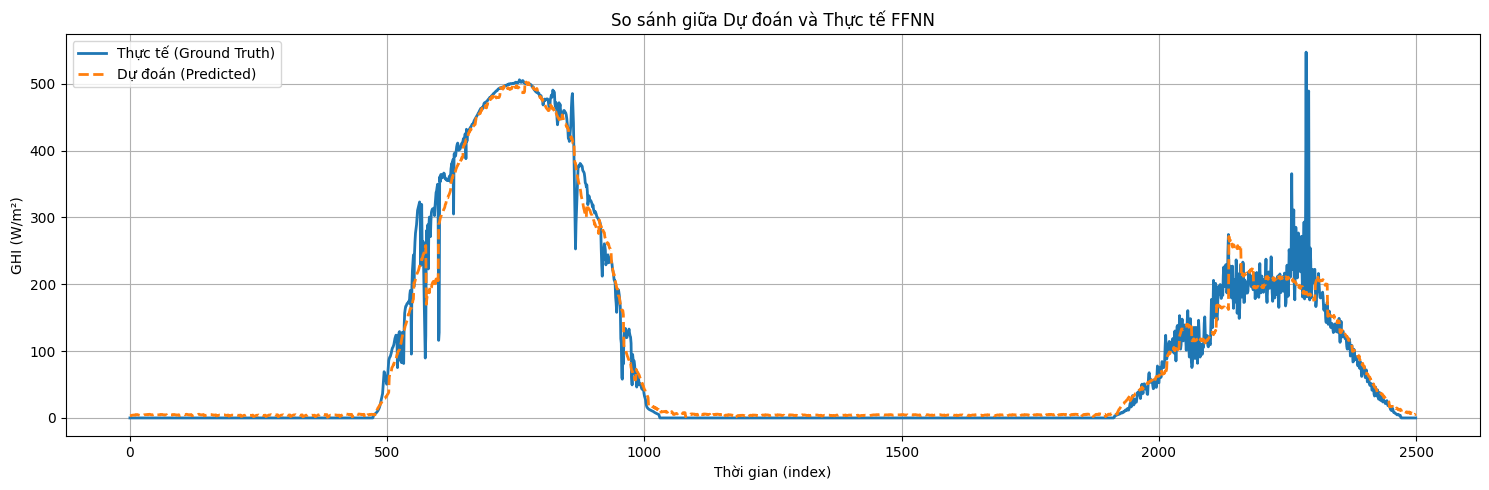

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(all_targets[:2500], label='Thực tế (Ground Truth)', linewidth=2)
plt.plot(all_scores[:2500], label='Dự đoán (Predicted)', linewidth=2, linestyle='--')

plt.title('So sánh giữa Dự đoán và Thực tế FFNN')
plt.xlabel('Thời gian (index)')
plt.ylabel('GHI (W/m²)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
from torchinfo import summary

summary(model, input_size=(16, 24, 8))

Layer (type:depth-idx)                   Output Shape              Param #
GRU_CNN                                  [16, 24]                  --
├─GRU: 1-1                               [16, 24, 64]              --
│    └─GRU: 2-1                          [16, 24, 64]              39,168
├─CNN: 1-2                               [16, 24]                  --
│    └─Conv1d: 2-2                       [16, 64, 24]              12,352
│    └─MaxPool1d: 2-3                    [16, 64, 12]              --
│    └─Conv1d: 2-4                       [16, 128, 12]             24,704
│    └─MaxPool1d: 2-5                    [16, 128, 6]              --
│    └─Flatten: 2-6                      [16, 768]                 --
│    └─Dropout: 2-7                      [16, 768]                 --
│    └─Linear: 2-8                       [16, 256]                 196,864
│    └─Linear: 2-9                       [16, 24]                  6,168
Total params: 279,256
Trainable params: 279,256
Non-trainable par